In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import List


In [2]:
############Clase################
class ModeloRegresion:
    def __init__(self, df: pd.DataFrame, variable_respuesta: str, ) -> None:
        self.df = df
        self.variable_respuesta= variable_respuesta
        self.variables_correlacionadas = []
        self.df_desfase = None
        self.model = None
    
    def calcular_correlacion_variables(self, threshold:float) -> List[str]:
        """
        Calcula la correlación de todas las variables con la variable objetivo y retorna un informe de las variables
        con una correlación absoluta mayor al threshold dado.
        """
        # Obtener variables con correlación mayor a 0.3
        correlaciones = self.df.corr()[self.variable_explicativa]
        variables = correlaciones.index
        correlaciones = correlaciones.values
        correlaciones_mayores_a_threshold = {
            'variable': [],
            'correlacion': [],
        }
        for i in range(len(variables)):
            print(f'{variables[i]}: {correlaciones[i]}')
            if np.absolute(correlaciones[i]) > 0.3:
                correlaciones_mayores_a_threshold['variable'].append(variables[i])
                correlaciones_mayores_a_threshold['correlacion'].append(correlaciones[i])
        
        
        return correlaciones_mayores_a_threshold
    
    def calcular_correlacion_variables_desfase(self, threshold: float, desfases: List[int]) -> List[dict]:
        """
        Calcula la correlación entre la variable explicativa y las variables predictoras con desfase de 1, 3, 6, y 12 meses.
        Retorna un informe de las variables con una correlación absoluta mayor al threshold dado para cada desfase.
        """
        correlaciones_mayores_desfase = []
        for desfase in desfases:
            # Crear dataframe con desfase
            df_desfase = self.df[self.variable_respuesta].to_frame()
            for variable in self.df.columns:
                if variable != self.variable_respuesta:
                    df_desfase[f'{variable}_d{desfase}' if desfase == 12 else f'{variable}_d0{desfase}'] = self.df[variable].shift(desfase)

            # Calcular correlaciones con desfase
            correlaciones = df_desfase.corr()[self.variable_respuesta]
            variables = correlaciones.index
            correlaciones = correlaciones.values
            correlaciones_mayores_a_threshold = {
                'variable': [],
                'correlacion': [],
            }
            for i in range(len(variables)):
                if correlaciones[i] > threshold:
                    correlaciones_mayores_a_threshold['variable'].append(variables[i])
                    correlaciones_mayores_a_threshold['correlacion'].append(correlaciones[i])
            
            # Agregar resultado a lista de desfases
            correlaciones_mayores_desfase.append({
                'desfase': desfase,
                'correlaciones': correlaciones_mayores_a_threshold
            })

        return correlaciones_mayores_desfase
    
        
    def mejor_correlacion_variable_y_desfase(self, threshold: float, desfases: List[int]) -> pd.DataFrame:
        """
        Retorna la mejor correlación para cada variable, indicando el desfase correspondiente y la correlación obtenida.
        """
        correlaciones_mayores_desfase = self.calcular_correlacion_variables_desfase(threshold, desfases)
        #mejores correlaciones de todos los desfases por variable
        mejores_correlaciones = {
        }
        lista_df = []
        lista_desfases = desfases
        for i in range(len(correlaciones_mayores_desfase)):
            print('dataframe con desfase: ',lista_desfases[i])
            df = pd.DataFrame(correlaciones_mayores_desfase[i]['correlaciones'])
            df['desfase_meses'] = lista_desfases[i]
            lista_df.append(df)
            
        mejores_correlaciones = pd.concat(lista_df)
        #extraer las mejores correlaciones por variable si es que la variable tiene mas de un desfase dejar la más alta
        mejores_correlaciones = mejores_correlaciones.groupby('variable').max()
        mejores_correlaciones = mejores_correlaciones.reset_index()
        duplicados = mejores_correlaciones['variable'].str[:-4].duplicated(keep=False)
        # Filtramos las filas duplicadas y nos quedamos con la que tenga el valor más alto en "correlaciones"
        resultado = pd.concat([
            mejores_correlaciones[~duplicados],
            mejores_correlaciones[duplicados].sort_values('correlacion').drop_duplicates('variable', keep='last')
        ])        
        resultado = resultado.sort_values('correlacion', ascending=False)
        for i in range(len(resultado['variable'])):
            if resultado['variable'][i] != self.variable_respuesta:
                resultado['variable'][i] = resultado['variable'][i][:-4]
            else:
                resultado['variable'][i] = resultado['variable'][i]
        return resultado
    
    def hacer_df_por_desfase(self, threshold: float, desfases: List[int]) -> List[pd.DataFrame]:
        """
        Retorna un dataframe con las variables predictoras y la variable objetivo con el desfase dado.
        """
        df_desfase = self.mejor_correlacion_variable_y_desfase(threshold, desfases)
        df_desfase = df_desfase[df_desfase['variable'] != self.variable_respuesta]
        df_desfase = df_desfase.reset_index(drop=True)
        df_desfase = df_desfase.drop(columns=['correlacion'])
        # Hacer un dataframe con la variable objetivo y las variables predictoras con el desfase dado
        df_vacio = pd.DataFrame()
        df_list = []
        for i in range(len(df_desfase['variable'])):
            for j in range(len(desfases)):
                if df_desfase['variable'][i] != self.variable_respuesta:
                    df_vacio[df_desfase['variable'][i]] = self.df[df_desfase['variable'][i]].shift(df_desfase['desfase_meses'][i])
            df_vacio[self.variable_respuesta] = self.df[self.variable_respuesta]
            df_vacio.dropna(axis=0, how='any')
            df_list.append(df_vacio)
        return df_list            
                


    def df_with_lag(self, threshold: float, desfases: List[int]):
        
        mejor_df = self.mejor_correlacion_variable_y_desfase(0.3, [1, 3, 6, 12])
        dict_desfases = {}
        for i in range(len(mejor_df['variable'])):
            dict_desfases[mejor_df['variable'][i]] = mejor_df['desfase_meses'][i]
        
        # Aplicar desfases 
        df_lag = self.df.copy()
        for variable in df_lag.columns:
            if variable != self.variable_respuesta and variable in dict_desfases.keys():
                self.df[variable] = self.df[variable].shift(dict_desfases[variable])
            if variable not in dict_desfases.keys():
                self.df = self.df.drop(columns=[variable])
        self.df_desfase = self.df.dropna(axis=0, how='any')
        return self.df_desfase
    def regresion_linear_multiple(self):
        """_summary_lineal_regression_multiple
        """
        df_desfase = self.df_with_lag(0.3, [1, 3, 6, 12])
        self.df_desfase = df_desfase
        X = df_desfase.drop(columns=[self.variable_respuesta])
        y = df_desfase[self.variable_respuesta]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
        reg = LinearRegression().fit(X_train, y_train)
        self.model = reg
        y_pred = reg.predict(X_test)
        print('R2: ', r2_score(y_test, y_pred))
        print('MAE: ', mean_absolute_error(y_test, y_pred))
        print('MSE: ', mean_squared_error(y_test, y_pred))
        print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        print('MAPE: ', mean_absolute_percentage_error(y_test, y_pred))
        print('SMAPE: ', symmetric_mean_absolute_percentage_error(y_test, y_pred))
        y_pred = reg.predict(X_test)
        plt.figure(figsize=(20, 10))
        plt.plot(y_test, label='Real')
        plt.plot(y_pred, label='Predicción')
        plt.legend()
        plt.show()
        
    def plot_train(self):
        """_summary_plot_test
        """
        df = self.df_desfase
        X = df.drop(columns=[self.variable_respuesta])
        y = df[self.variable_respuesta]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_train)
        plt.figure(figsize=(20, 10))
        plt.plot(y_train, label='Real')
        plt.plot(y_pred, label='Predicción')
        plt.legend()
        plt.show()
        

In [3]:
import pandas as pd
df = pd.read_csv('./data/df_definitivo_100%.csv', index_col='fecha')
#Tomar solo los datos desde 2010
df = df.loc['2005-01-01':'2023-01-01']
variable_respuesta = 'IPC General histórico, variación mensual'
df = df.dropna(axis=1, how='any')
reg = ModeloRegresion(df, variable_respuesta)
mejor_df = reg.mejor_correlacion_variable_y_desfase(0.3, [1, 3, 6, 12])
df_lag = reg.df_with_lag(0.3, [1,3,6,12])
#reg.regresion_linear_multiple()

C:\Users\israe\AppData\Local\Temp\ipykernel_16792\233561625.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_desfase[f'{variable}_d{desfase}' if desfase == 12 else f'{variable}_d0{desfase}'] = self.df[variable].shift(desfase)
C:\Users\israe\AppData\Local\Temp\ipykernel_16792\233561625.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_desfase[f'{variable}_d{desfase}' if desfase == 12 else f'{variable}_d0{desfase}'] = self.df[variable].shift(desfase)
C:\Users\israe\AppData\Local\Temp\ipykernel_16792\233561625.py:43: P

dataframe con desfase:  1
dataframe con desfase:  3
dataframe con desfase:  6
dataframe con desfase:  12


C:\Users\israe\AppData\Local\Temp\ipykernel_16792\233561625.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado['variable'][i] = resultado['variable'][i][:-4]
C:\Users\israe\AppData\Local\Temp\ipykernel_16792\233561625.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado['variable'][i] = resultado['variable'][i][:-4]
C:\Users\israe\AppData\Local\Temp\ipykernel_16792\233561625.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

dataframe con desfase:  1
dataframe con desfase:  3
dataframe con desfase:  6
dataframe con desfase:  12


C:\Users\israe\AppData\Local\Temp\ipykernel_16792\233561625.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado['variable'][i] = resultado['variable'][i][:-4]
C:\Users\israe\AppData\Local\Temp\ipykernel_16792\233561625.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultado['variable'][i] = resultado['variable'][i][:-4]
C:\Users\israe\AppData\Local\Temp\ipykernel_16792\233561625.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [4]:
df_lag

IPC General histórico, variación mismo período año anterior, BCCh  \
fecha                                                                           
2006-01-01                                           3.666547                   
2006-02-01                                           4.080733                   
2006-03-01                                           4.078384                   
2006-04-01                                           4.026941                   
2006-05-01                                           3.768413                   
...                                                       ...                   
2022-09-01                                          14.084662                   
2022-10-01                                          13.731332                   
2022-11-01                                          12.806637                   
2022-12-01                                          13.341457                   
2023-01-01                                          12.781654                   

            IPC General histórico, variación mensual, BCCh  \
fecha                                                        
2006-01-01                                       -0.358877   
2006-02-01                                        0.083202   
2006-03-01                                       -0.093897   
2006-04-01                                        0.586132   
2006-05-01                                        0.647370   
...                                                    ...   
2022-09-01                                        1.210923   
2022-10-01                                        0.864521   
2022-11-01                                        0.517062   
2022-12-01                                        0.975245   
2023-01-01                                        0.283635   

            IPC sin volátiles, variación mensual  \
fecha                                              
2006-01-01                              0.240522   
2006-02-01                              0.114812   
2006-03-01                              0.288224   
2006-04-01                              0.217442   
2006-05-01                              0.156677   
...                                          ...   
2022-09-01                              1.500000   
2022-10-01                              1.100000   
2022-11-01                              0.900000   
2022-12-01                              0.700000   
2023-01-01                              0.900000   

            IPC volátil, variación mismo periodo año anterior  \
fecha                                                           
2006-01-01                                           5.645812   
2006-02-01                                           6.788421   
2006-03-01                                           6.641161   
2006-04-01                                           5.801490   
2006-05-01                                           4.717222   
...                                                       ...   
2022-09-01                                          20.116255   
2022-10-01                                          18.498457   
2022-11-01                                          16.294873   
2022-12-01                                          17.409013   
2023-01-01                                          16.516913   

            IPC volátil, variación mensual  \
fecha                                        
2006-01-01                       -1.185732   
2006-02-01                        0.181891   
2006-03-01                       -0.604437   
2006-04-01                        0.055439   
2006-05-01                        0.973295   
...                                    ...   
2022-09-01                        1.801882   
2022-10-01                        0.619656   
2022-11-01                        1.237944   
2022-12-01                        1.024810   
2023-01-01                        0.195912   

            IMCE: Comercio, E

In [5]:
import pandas as pd

# Obtener la matriz de correlación
correlation_matrix = df_lag.corr()

# Crear la tabla de variables y sus máximas correlaciones
table_data = []
for column in correlation_matrix.columns:
    max_correlation = correlation_matrix[column].drop(column).abs().idxmax()
    max_correlation_value = correlation_matrix.loc[max_correlation, column]
    table_data.append([column, max_correlation, max_correlation_value])

# Crear el DataFrame de la tabla
table_df = pd.DataFrame(table_data, columns=['Variable Evaluada', 'Variable Mayor Correlación', 'Valor de Correlación'])

# Imprimir la tabla
table_df


Variable Evaluada  \
0    IPC General histórico, variación mismo período...   
1       IPC General histórico, variación mensual, BCCh   
2                 IPC sin volátiles, variación mensual   
3    IPC volátil, variación mismo periodo año anterior   
4                       IPC volátil, variación mensual   
..                                                 ...   
158                      Saldo pasivos monetarios BCCh   
159  Pasivos monetarios BCCh, saldo en bonos y pagarés   
160  IPC General, variación mismo período año anter...   
161           IPC General histórico, variación mensual   
162               IPC SAE histórico, variación mensual   

                            Variable Mayor Correlación  Valor de Correlación  
0    IPC General, variación mismo período año anter...              0.999930  
1                       IPC volátil, variación mensual              0.902042  
2          IPC Bienes sin volátiles, variación mensual              0.802002  
3    IPC General, variación mismo período año anter...              0.933890  
4       IPC General histórico, variación mensual, BCCh              0.902042  
..                                                 ...                   ...  
158                                 Saldo activos BCCh              1.000000  
159                      Saldo pasivos monetarios BCCh              0.959166  
160  IPC General histórico, variación mismo período...              0.999930  
161     IPC General histórico, variación mensual, BCCh              0.492219  
162  IPC General histórico, variación mismo período...              0.529219  

[163 rows x 3 columns]

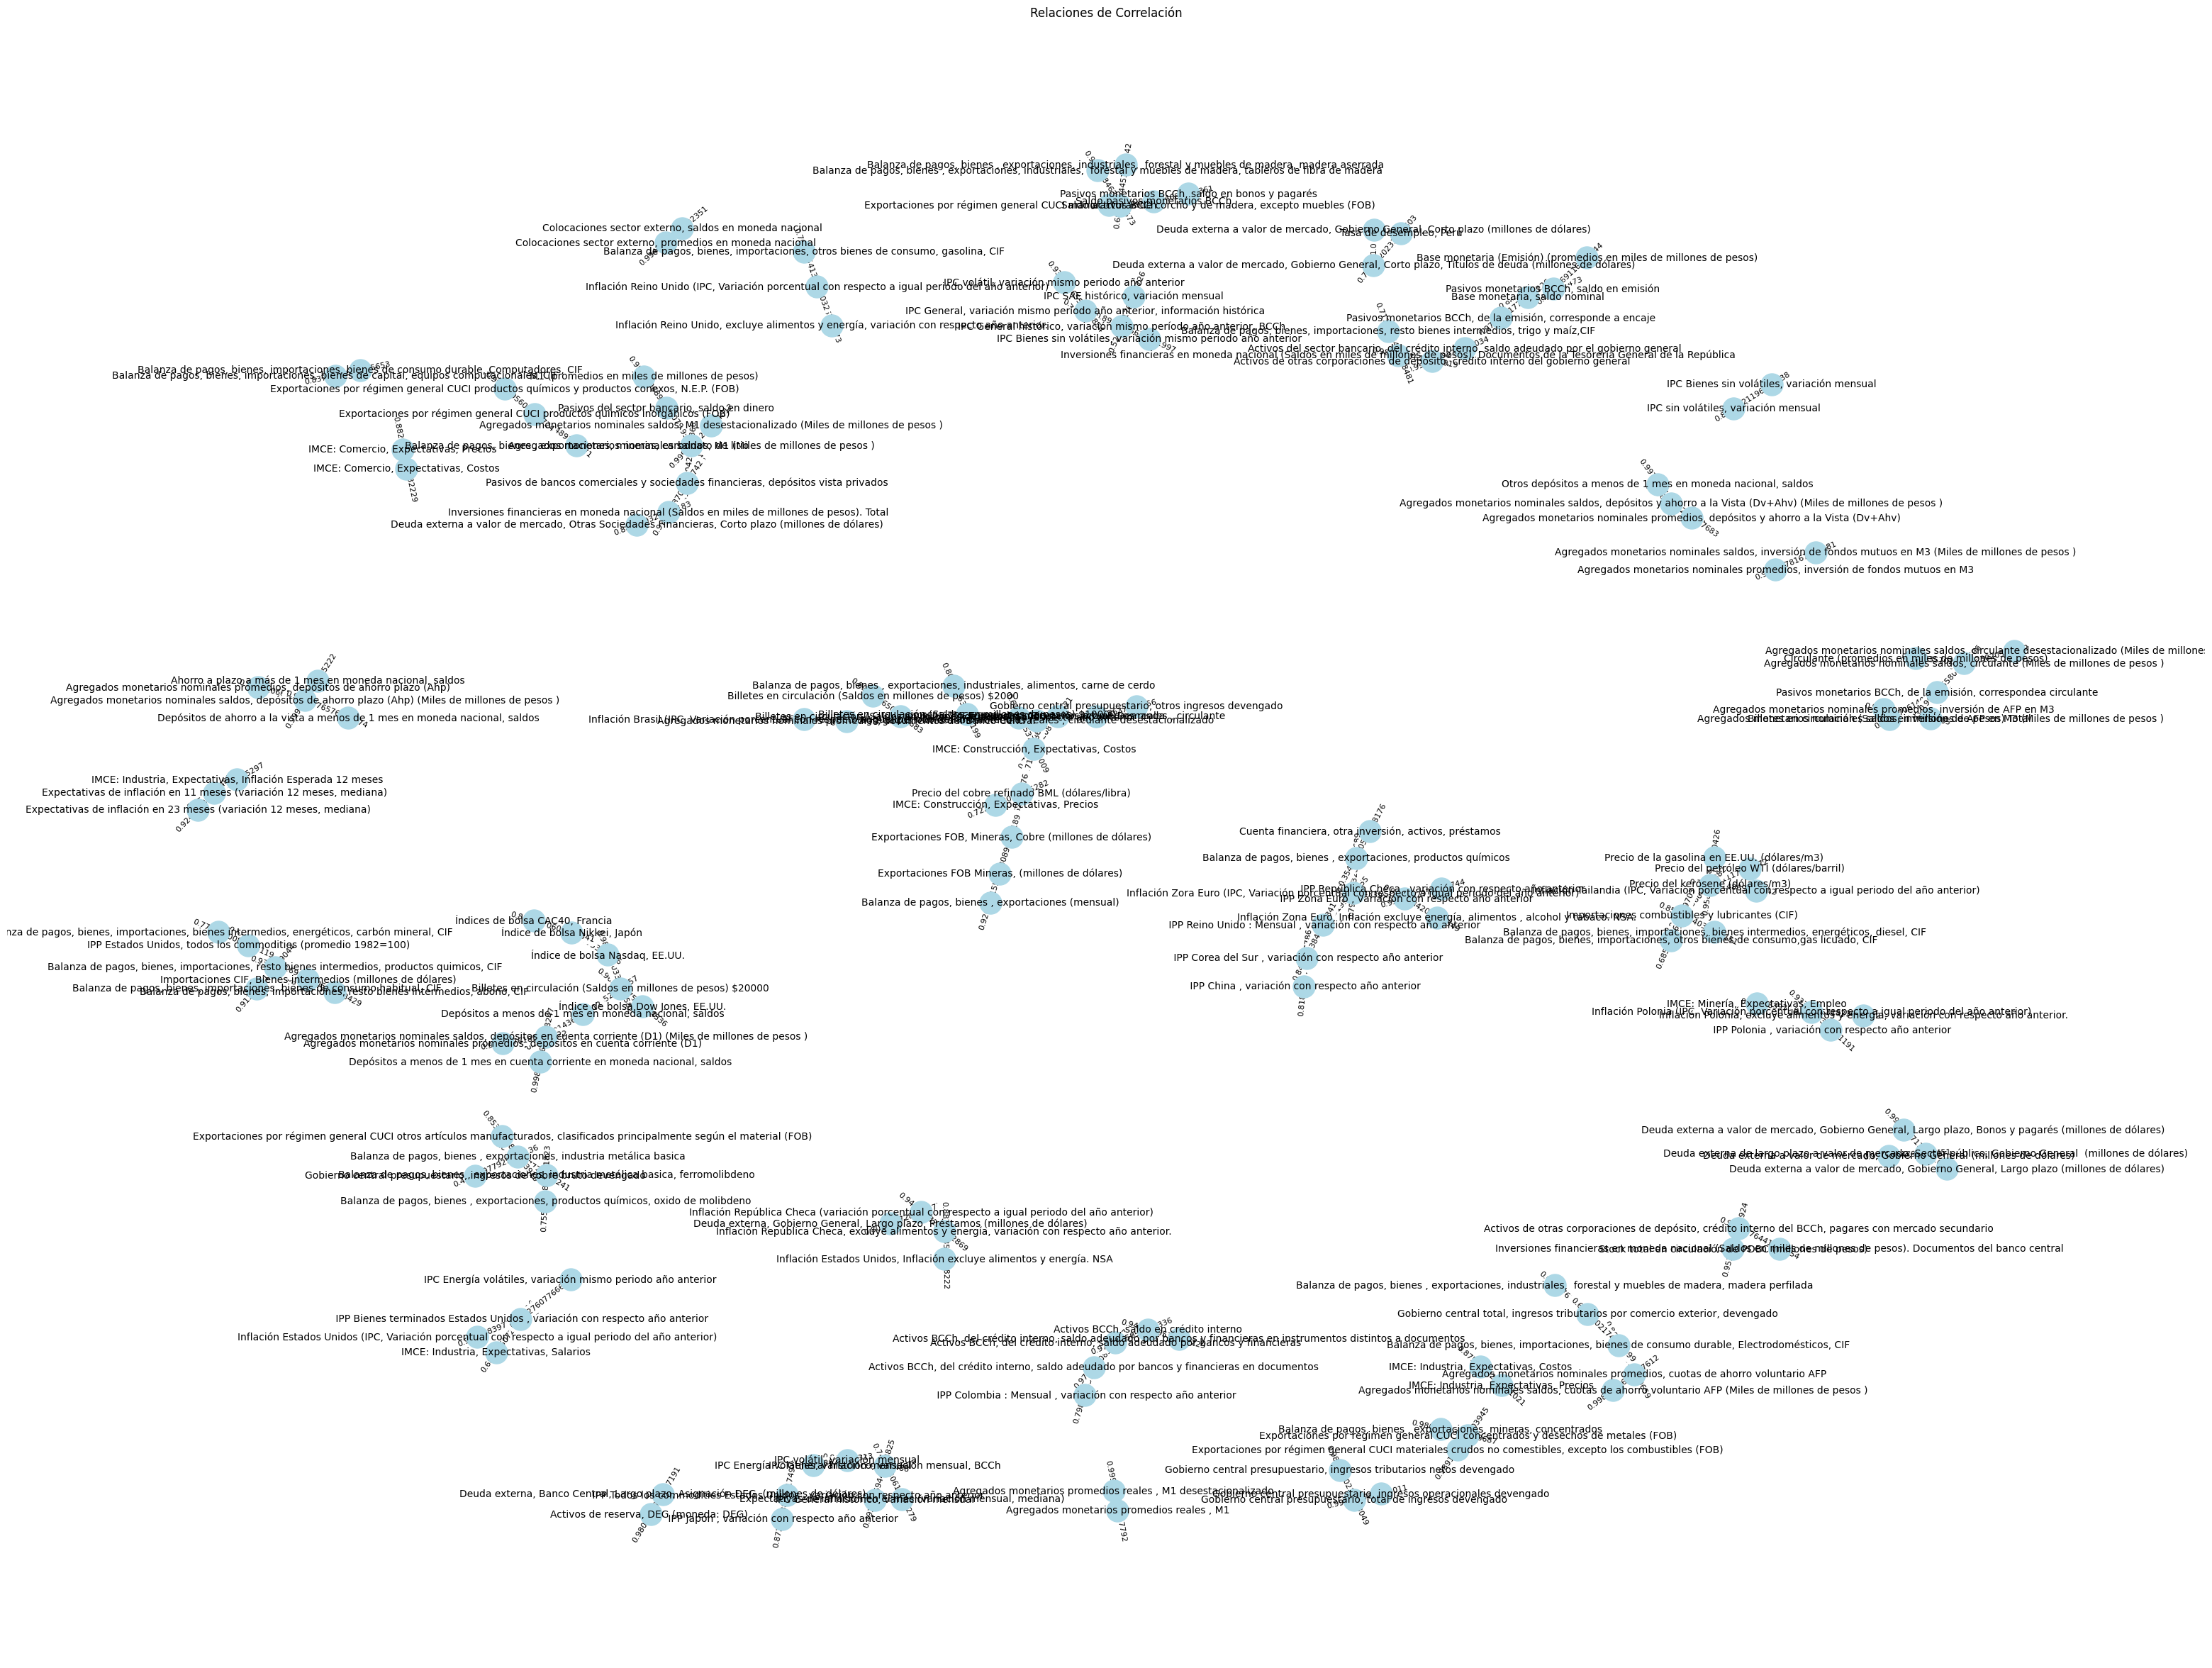

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Crear el grafo
G = nx.from_pandas_edgelist(table_df, 'Variable Evaluada', 'Variable Mayor Correlación', ['Valor de Correlación'])

# Definir la posición de los nodos en el grafo
pos = nx.spring_layout(G)

# Obtener los valores de correlación como etiquetas en los enlaces
edge_labels = nx.get_edge_attributes(G, 'Valor de Correlación')

# Graficar el grafo
plt.figure(figsize=(40, 30))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Personalizar la visualización del grafo
plt.title('Relaciones de Correlación')
plt.axis('off')

# Mostrar el gráfico
plt.show()


In [7]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'

# Crear el grafo
G = nx.from_pandas_edgelist(table_df, 'Variable Evaluada', 'Variable Mayor Correlación', ['Valor de Correlación'])

# Obtener las posiciones de los nodos en el grafo
pos = nx.spring_layout(G)

# Obtener las posiciones x, y de los nodos
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# Crear las aristas del grafo
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Agregar las coordenadas de las aristas
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# Crear los nodos del grafo
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Valor de Correlación',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    )
)

# Agregar los valores de correlación como texto en los nodos
node_text = []
for node in G.nodes():
    node_text.append(f'{node}<br>Valor de Correlación: {table_df.loc[table_df["Variable Evaluada"] == node, "Valor de Correlación"].values[0]}')

node_trace.text = node_text

# Crear la figura del grafo
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Relaciones de Correlación',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[
                        dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002
                        )
                    ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
                )

# Renderizar y mostrar el gráfico en el navegador local
pio.show(fig)

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50916)
Traceback (most recent call last):
  File "C:\Users\israe\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\israe\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\israe\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\israe\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "C:\Users\israe\AppData\Local\Programs\Python\Python310\lib\http\server.py", line 433, in handle
    self.handle_one_request()
  File "C:\Users\israe\AppData\Local\Programs\Python\Python310\lib\http\server.py",

In [8]:
import networkx as nx

# Obtener las comunidades utilizando el algoritmo de Louvain
partition = nx.community.label_propagation_communities(G)

# Crear un diccionario para almacenar los grupos y sus nodos correspondientes
groups = {}
for i, nodes in enumerate(partition):
    groups[i] = list(nodes)

# Encontrar los grupos aislados
isolated_groups = []
for group, nodes in groups.items():
    isolated = True
    for other_group, other_nodes in groups.items():
        if group != other_group:
            if any(G.has_edge(node, other_node) for node in nodes for other_node in other_nodes):
                isolated = False
                break
    if isolated:
        isolated_groups.append(nodes)

# Imprimir los grupos aislados
contador = 1
lista_grupos = []
for group in isolated_groups:
    print(f"Grupo aislado {contador}:", group)
    n_grupo = "Grupo " + str(contador)
    lista_grupos.append((n_grupo, group))
    contador += 1
    
lista_grupos

Grupo aislado 1: ['IPC Bienes sin volátiles, variación mensual', 'IPC sin volátiles, variación mensual']
Grupo aislado 2: ['IMCE: Comercio, Expectativas, Precios', 'IMCE: Comercio, Expectativas, Costos']
Grupo aislado 3: ['IMCE: Industria, Expectativas, Costos', 'IMCE: Industria, Expectativas, Precios']
Grupo aislado 4: ['IMCE: Industria, Expectativas, Salarios', 'Inflación Estados Unidos (IPC, Variación porcentual con respecto a igual periodo del año anterior)', 'IPC Energía volátiles, variación mismo periodo año anterior', ' IPP Bienes terminados Estados Unidos , variación con respecto año anterior']
Grupo aislado 5: ['IMCE: Industria, Expectativas, Inflación Esperada 12 meses', 'Expectativas de inflación en 11 meses (variación 12 meses, mediana)', 'Expectativas de inflación en 23 meses (variación 12 meses, mediana)']
Grupo aislado 6: ['Inflación Polonia, excluye alimentos y energía, variación con respecto año anterior.', 'Inflación Polonia (IPC, Variación porcentual con respecto a i

[('Grupo 1',
  ['IPC Bienes sin volátiles, variación mensual',
   'IPC sin volátiles, variación mensual']),
 ('Grupo 2',
  ['IMCE: Comercio, Expectativas, Precios',
   'IMCE: Comercio, Expectativas, Costos']),
 ('Grupo 3',
  ['IMCE: Industria, Expectativas, Costos',
   'IMCE: Industria, Expectativas, Precios']),
 ('Grupo 4',
  ['IMCE: Industria, Expectativas, Salarios',
   'Inflación Estados Unidos (IPC, Variación porcentual con respecto a igual periodo del año anterior)',
   'IPC Energía volátiles, variación mismo periodo año anterior',
   ' IPP Bienes terminados Estados Unidos , variación con respecto año anterior']),
 ('Grupo 5',
  ['IMCE: Industria, Expectativas, Inflación Esperada 12 meses',
   'Expectativas de inflación en 11 meses (variación 12 meses, mediana)',
   'Expectativas de inflación en 23 meses (variación 12 meses, mediana)']),
 ('Grupo 6',
  ['Inflación Polonia, excluye alimentos y energía, variación con respecto año anterior.',
   'Inflación Polonia (IPC, Variación po

In [9]:
# Sacar la variable con mayor correlacion de los grupos aislados con la varibale_respuesta
lista_para_model = []
for lista_columna in lista_grupos:
    if variable_respuesta in lista_columna[1]:
        lista_grupos.remove(lista_columna[1])
        continue
    # Extraer df de cada grupo
    df_grupo = df_lag[lista_columna[1]]
    # calcular la variable con mayor correlacion de los grupos aislados con la varibale_respuesta
    lista_correlacion = []
   
    for columna in df_grupo.columns:
        df_correlacion = df_lag[[variable_respuesta, columna]].corr()
        correlacion = df_correlacion.iloc[0,1]
        lista_correlacion.append(correlacion)
    # Sacar la variable con mayor correlacion de los grupos aislados con la varibale_respuesta
    max_correlacion = max(lista_correlacion)
    indice_max_correlacion = lista_correlacion.index(max_correlacion)
    variable_max_correlacion = df_grupo.columns[indice_max_correlacion]
    # Hacer lista con las mejores variables de cada grupo
    lista_para_model.append(variable_max_correlacion)
    print(f"La variable con mayor correlacion del {lista_columna[0]} es: {variable_max_correlacion}") 

La variable con mayor correlacion del Grupo 1 es: IPC Bienes sin volátiles, variación mensual
La variable con mayor correlacion del Grupo 2 es: IMCE: Comercio, Expectativas, Costos
La variable con mayor correlacion del Grupo 3 es: IMCE: Industria, Expectativas, Precios
La variable con mayor correlacion del Grupo 4 es: IPC Energía volátiles, variación mismo periodo año anterior
La variable con mayor correlacion del Grupo 5 es: Expectativas de inflación en 11 meses (variación 12 meses, mediana)
La variable con mayor correlacion del Grupo 6 es: Inflación Polonia (IPC, Variación porcentual con respecto a igual periodo del año anterior)
La variable con mayor correlacion del Grupo 7 es: Deuda externa a valor de mercado, Gobierno General, Corto plazo (millones de dólares)
La variable con mayor correlacion del Grupo 8 es: Balanza de pagos, bienes, importaciones, bienes intermedios, energéticos, diesel, CIF
La variable con mayor correlacion del Grupo 9 es: Inflación Reino Unido, excluye aliment

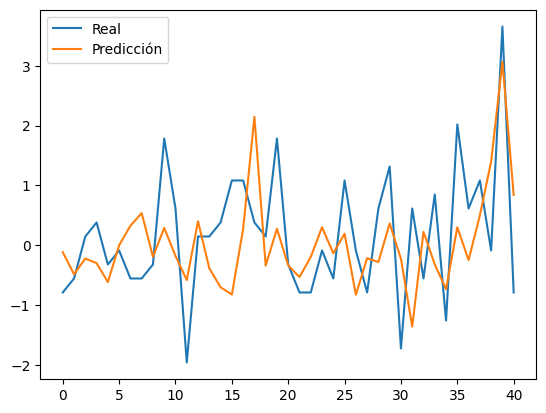

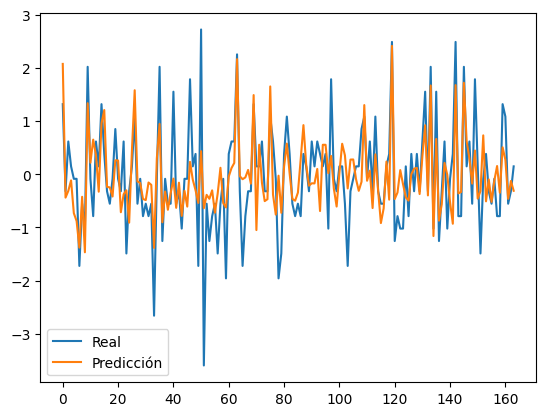

In [10]:
# Hacer regresion lineal con las variables con mayor correlacion de los grupos aislados con la varibale_respuesta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = df_lag[[variable_respuesta] + lista_para_model]
X = df.drop(variable_respuesta, axis=1)
y = df[variable_respuesta]

# Estandarizar los datos
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.values.reshape(-1,1))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# Plor the results en grafico de lineas
plt.plot(y_test, label='Real')
plt.plot(y_pred, label='Predicción')
plt.legend()
plt.show()
# Graficar train
plt.plot(y_train, label='Real')
plt.plot(reg.predict(X_train), label='Predicción')
plt.legend()
plt.show()